In [2]:
from langchain_ollama.llms import OllamaLLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf
import equity_simulator as es

# model = "deepseek-r1"
# llm = OllamaLLM(model=model)

In [18]:

stocks =  ['AAPL', 'SHEL', 'JPM', 'COST']
start, end = dt.now() - timedelta(days=300), dt.now()

# stock_data = yf.download(stocks, start, end)
# stock_data = stock_data['Close']
# stock_data.head()

# Generate date range for one year
date_range = pd.date_range(start=start, end=end, freq='B')

# Generate random stock prices
np.random.seed(42)  # For reproducibility
dummy_data = {
    'JANU': np.random.uniform(low=100, high=200, size=len(date_range)),
    'MANU': np.random.uniform(low=50, high=150, size=len(date_range)),
    'SANU': np.random.uniform(low=200, high=300, size=len(date_range)),
    'DANU': np.random.uniform(low=150, high=250, size=len(date_range))
}

# Create a DataFrame
stock_data = pd.DataFrame(dummy_data, index=date_range)
stock_data['Date'] = stock_data.index.astype(int)
stock_data = stock_data[['Date', 'JANU', 'MANU', 'SANU', 'DANU']]
stock_data.head()

C:\Users\bono1\AppData\Local\Temp\ipykernel_11796\4087936369.py:22: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  stock_data['Date'] = stock_data.index.astype(int)


,Date,JANU,MANU,SANU,DANU
2024-05-13 16:02:48.578519,1715616168578519000,137.454012,73.724909,214.299168,239.052728
2024-05-14 16:02:48.578519,1715702568578519000,195.071431,82.539970,276.151063,209.359245
2024-05-15 16:02:48.578519,1715788968578519000,173.199394,124.649141,261.821806,217.910232
2024-05-16 16:02:48.578519,1715875368578519000,159.865848,114.963290,210.112268,228.917124
2024-05-17 16:02:48.578519,1715961768578519000,115.601864,134.922341,208.410681,199.844220


In [19]:
A = es.EquityPortfolio()
A.setHistoricPrices(stock_data.values)
A.setWeights([0.25, 0.25, 0.25, 0.25])
A.calculateMeanReturns()
display(A.getMeanReturns())
A.calculateCovMatrix()
display(A.getCovarianceMatrix())
A.setMontoCarloParameters(50, 100)

array([0.04251744, 0.09189904, 0.01353223, 0.02047482])

array([[ 0.09300307, -0.00110639,  0.00048048,  0.00987036],
       [-0.00110639,  0.23433673,  0.00048259,  0.00435037],
       [ 0.00048048,  0.00048259,  0.02821024, -0.00203585],
       [ 0.00987036,  0.00435037, -0.00203585,  0.04734768]])

In [20]:
A.runSimulation()
simulation_data = A.returnSimulationResults()

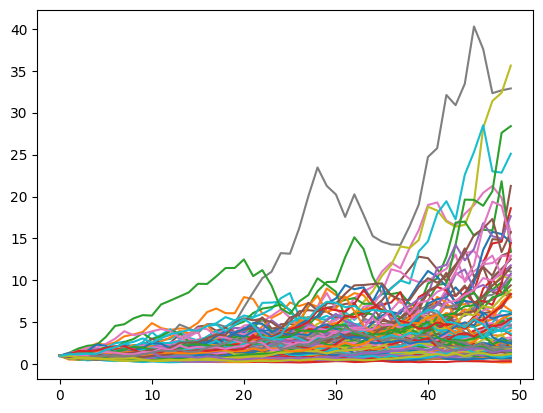

In [21]:
import matplotlib.pyplot as plt
plt.plot(simulation_data)

In [13]:
import numpy as np
print(np.clip(np.array(255, np.uint8), 0, 255) + np.clip(np.array(1, np.uint8), 0, 255))

0


C:\Users\bono1\AppData\Local\Temp\ipykernel_36148\2058199952.py:2: RuntimeWarning: overflow encountered in scalar add
  print(np.clip(np.array(255, np.uint8), 0, 255) + np.clip(np.array(1, np.uint8), 0, 255))


In [5]:
np.array(255, np.uint8) + np.array(1, np.uint8)

np.uint8(0)

In [10]:
np.iinfo(np.uint8).max

255

In [5]:
import duckdb
import pandas as _pd

display(duckdb.version())
duckdb.install_extension('ducklake')
duckdb.load_extension('ducklake')

# open a connection
conn = duckdb.connect('duckdb_1.db')

# create DuckDB tables from CSVs (adjust file paths if necessary)
conn.execute("CREATE TABLE IF NOT EXISTS strt_exec AS SELECT * FROM read_csv_auto('strt_exec_v3.csv') LIMIT 0")
conn.execute("INSERT INTO strt_exec SELECT * FROM read_csv_auto('strt_exec_v3.csv')")

conn.execute("CREATE TABLE IF NOT EXISTS syst_exec AS SELECT * FROM read_csv_auto('syst_exec_v3.csv') LIMIT 0")
conn.execute("INSERT INTO syst_exec SELECT * FROM read_csv_auto('syst_exec_v3.csv')")

# helper to upsert from CSV into an existing table using MERGE (detect changes and apply updates/inserts)
def upsert_from_csv(conn, table_name, csv_path, key=None, delete_missing=False):
    # load CSV header to get columns
    cols = list(_pd.read_csv(csv_path, nrows=0).columns)
    if not cols:
        raise ValueError("No columns found in CSV: " + csv_path)

    # pick a key if not provided (prefer common names)
    if key is None:
        for cand in ("id", "ID", "Id", "key", "Key"):
            if cand in cols:
                key = cand
                break
        if key is None:
            key = cols[0]  # fallback to first column

    # quote identifiers
    def q(name): 
        return '"' + str(name).replace('"', '""') + '"'

    non_key_cols = [c for c in cols if c != key]
    if not non_key_cols:
        raise ValueError("No non-key columns to update for table " + table_name)

    # create a temporary table from the CSV
    temp_name = "new_" + table_name
    conn.execute(f"CREATE TEMPORARY TABLE {temp_name} AS SELECT * FROM read_csv_auto('{csv_path}')")

    # build MERGE statement
    set_clause = ", ".join([f'{q(col)} = source.{q(col)}' for col in non_key_cols])
    insert_cols = ", ".join([q(c) for c in cols])
    insert_vals = ", ".join([f"source.{q(c)}" for c in cols])
    merge_sql = f"""
    MERGE INTO {q(table_name)} AS target
    USING {temp_name} AS source
    ON target.{q(key)} = source.{q(key)}
    WHEN MATCHED AND ({' OR '.join([f'target.{q(c)} IS DISTINCT FROM source.{q(c)}' for c in non_key_cols])})
      THEN UPDATE SET {set_clause}
    WHEN NOT MATCHED THEN
      INSERT ({insert_cols}) VALUES ({insert_vals});
    """
    conn.execute(merge_sql)

    # optionally delete rows in target that are not present in source (detect deletions)
    if delete_missing:
        conn.execute(f"DELETE FROM {q(table_name)} WHERE {q(key)} NOT IN (SELECT {q(key)} FROM {temp_name})")

    # drop temp
    conn.execute(f"DROP TABLE IF EXISTS {temp_name}")

# Example: upsert strt_exec and syst_exec from CSVs, detect updates/inserts; also remove rows missing in CSV
upsert_from_csv(conn, "strt_exec", "strt_exec_v3.csv", key=None, delete_missing=False)
upsert_from_csv(conn, "syst_exec", "syst_exec_v3.csv", key=None, delete_missing=False)

# preview first rows
display(conn.execute("SELECT * FROM strt_exec LIMIT 5").df())
display(conn.execute("SELECT * FROM syst_exec LIMIT 5").df())

# read into pandas directly if preferred
df_strt = conn.execute("SELECT * FROM strt_exec").df()
df_syst = conn.execute("SELECT * FROM syst_exec").df()

'1.4.1 (with duckdb 1.4.1)'

,order_id,ticker,exec_time,order_side,exec_qty,exec_px
0,cx493190357869,STRT,2018-11-20,0,1,150.0
1,cx603022605810,STRT,2018-11-20,1,4,150.0
2,cx141183499645,STRT,2018-11-20,0,4,150.0
3,cx603022605810,STRT,2018-11-20,1,1,150.0
4,cx817058761907,STRT,2018-11-20,0,6,150.0


,order_id,ticker,exec_time,order_side,exec_qty,exec_px
0,cx947841297530,SYST,2018-11-20,0,1,100.0
1,cx896610364715,SYST,2018-11-20,1,5,100.0
2,cx947841297530,SYST,2018-11-20,0,1,100.0
3,cx770266849668,SYST,2018-11-20,1,5,100.0
4,cx947841297530,SYST,2018-11-20,0,5,100.0
